In [1]:
# Install needed stuff to the Jupyter and kernel environment

%pip install pyarrow
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install pyfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import needed stuff
import pyarrow.feather as feather
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
from pyfinance.options import BSM

In [3]:
# Delta-hedging function
def number_of_shares_to_buy(shares_per_contract, number_of_options, delta_of_option):
    delta_of_underlying = 1 # why?

    # Delta-hedging says:
    # number_of_shares * delta_of_underlying + number_of_options * delta_of_option = 0
    number_of_shares = (-number_of_options * delta_of_option / delta_of_underlying ) * shares_per_contract

    print("To delta-hedge the portoflio, you need to",("buy" if number_of_shares >= 0 else "sell"), round(np.abs(number_of_shares),2), "shares.")
    return number_of_shares


In [4]:
# Get volatility
def get_volatility(apple_stock_data):
    end_date = apple_stock_data.index.max()
    start_date = apple_stock_data.index.min()
    log_returns = np.log(apple_stock_data['Underlying']/apple_stock_data['Underlying'].shift(1)).dropna()
    #print(log_returns)
    volatility = log_returns.rolling(window = 21).std() * np.sqrt(252)
    #print(volatility)
    return volatility
    
    

In [5]:
# Read data and show it, data is from Refinitiv workspace
apple_stock_data_as_df = feather.read_feather('../data/fe2.feather')

# Set date to index instead of running index from 1..n
date_as_index = apple_stock_data_as_df.set_index('Date', inplace=False)
#print(date_as_index)
vola = get_volatility(date_as_index)

# Set values
shares_per_contract = 100 # How this is determined ?
number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?
call_delta = BSM(kind='call', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()
print("Delta of the call option:", call_delta)

put_delta = BSM(kind='put', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()
print("Delta of the put option:", put_delta)

x = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)
print(x)
y = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)
print(y)

Delta of the call option: 0.56291693680677
Delta of the put option: -0.43708306319323
To delta-hedge the portoflio, you need to sell 56.29 shares.
-56.291693680677
To delta-hedge the portoflio, you need to buy 43.71 shares.
43.708306319323


/tmp/ipykernel_40237/1134919854.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  call_delta = BSM(kind='call', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()
/tmp/ipykernel_40237/1134919854.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  put_delta = BSM(kind='put', S0=date_as_index['Underlying'][-1], K=date_as_index['Underlying'][-1], T=0.25, r=0.05, sigma=vola[-1]).delta()


In [6]:
vola.tail()

Date
2022-03-14    0.296315
2022-03-15    0.315905
2022-03-16    0.335212
2022-03-17    0.324049
2022-03-18    0.334705
Name: Underlying, dtype: float64

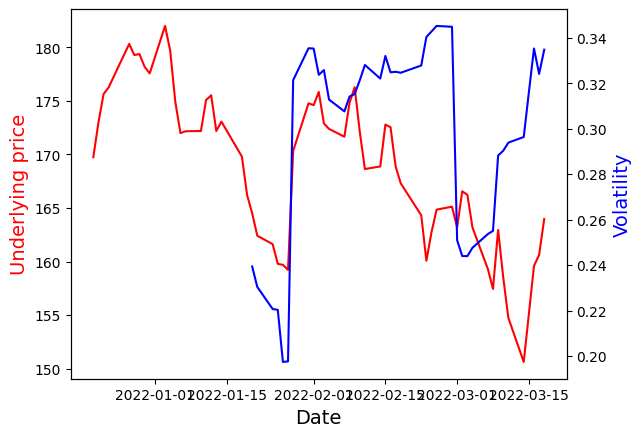

In [7]:
fig, ax = plt.subplots()
ax.plot(date_as_index['Underlying'], color='red')
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Underlying price', color='red', fontsize = 14)

ax2 = ax.twinx()
ax2.plot(vola, color = 'blue')
ax2.set_ylabel('Volatility', color = 'blue', fontsize = 14)

plt.show()